# Velocity calculation intercomparison

The purpose of this notebook is to make sure that the range_diff function is implemented correctly. We have already expanded it to be operable on a multidimensional array. Now, the goal is to make sure that the calculations align with more established methods. We will be attempting to compare with results from Irena Vankova's MATLAB ApRES processing scripts.

In [2]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../xapres/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    18:06:27 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    18:06:27 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    18:06:27 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG


We will use summer data from A104, since it seems to be the cleanest. We load in our A104 summer data as `ds_104`

In [3]:
# Loading site data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_104 = reload("A104")


In [4]:
# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33309")
client

<Client: 'tcp://127.0.0.1:33309' processes=4 threads=16, memory=125.81 GiB>

# Comparing bursts from 2 files
Let's look at 2 consecutive files from `ds_104` with clean data. We will take the first burst from each profile.

In [4]:
time1 = 893
time2 = 1081
print(f"Time = {time1} gives burst number {ds_104.isel(time=time1).burst_number.values} from {ds_104.isel(time=time1).filename.values}")
print(f"Time = {time2} gives burst number {ds_104.isel(time=time2).burst_number.values} from {ds_104.isel(time=time2).filename.values}")


Time = 893 gives burst number 0 from ldeo-glaciology/GL_apres_2022/A104/CardA/DIR2022-05-26-1748/DATA2022-06-04-1318.DAT
Time = 1081 gives burst number 0 from ldeo-glaciology/GL_apres_2022/A104/CardA/DIR2022-05-26-1748/DATA2022-06-06-1218.DAT


We therefore select the range of time between time indices 893 and 1081 to get two full files worth of data. Let's make sure that this data looks ok

In [5]:
ds_trimmed = ds_104.isel(attenuator_setting_pair = 0,time=range(893,1081)).compute()


Text(0.5, 1.0, 'A104 reflector amplitudes')

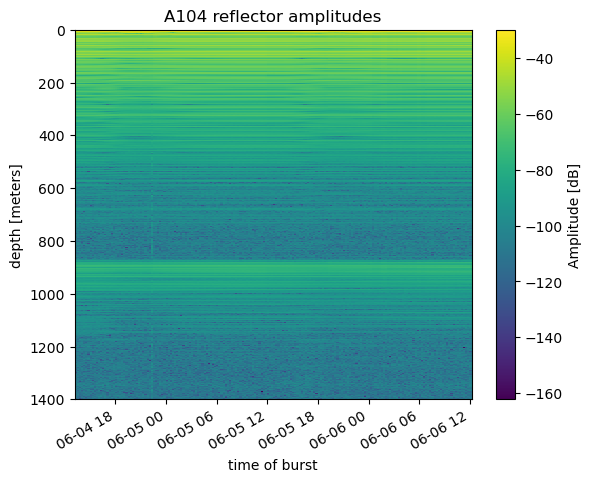

In [6]:
xa.dB(ds_trimmed.profile_stacked).plot(x='time',cbar_kwargs={'label':'Amplitude [dB]'})
plt.gca().invert_yaxis()
plt.title('A104 reflector amplitudes')


In general, with the exception of what appears to be a single burst that seems inconsistent, this data seems fine to work with. The comparison will start here, by comparing the stacked bursts. First, let's plot the profiles from the first bursts in each file.

Text(0, 0.5, 'amplitude [dB]')

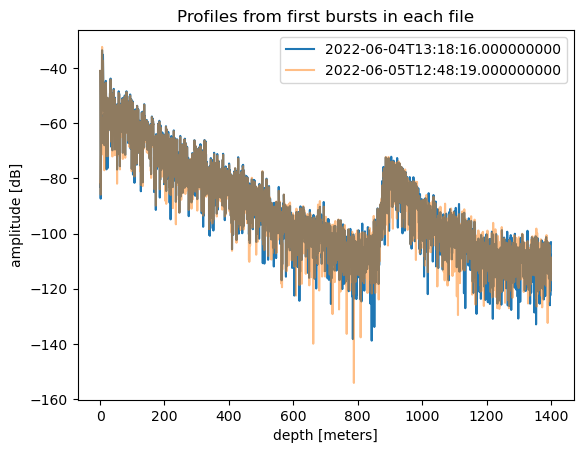

In [7]:
xa.dB(ds_trimmed.profile_stacked.isel(time=0)).plot(label=ds_trimmed.time.values[0])
xa.dB(ds_trimmed.profile_stacked.isel(time=94)).plot(alpha=0.5,label=ds_trimmed.time.values[94])
plt.legend()
plt.title('Profiles from first bursts in each file')
plt.ylabel('amplitude [dB]')

In [8]:
import scipy.io
mat = scipy.io.loadmat('site.mat')

In [9]:
profile_vankova_1 = mat['site'][0][0][0][0]
profile_vankova_2 = mat['site'][0][0][0][1]
range_vankova = mat['site'][-1][-1][-1][-1][-1][45][0]

Text(0, 0.5, 'amplitude [dB]')

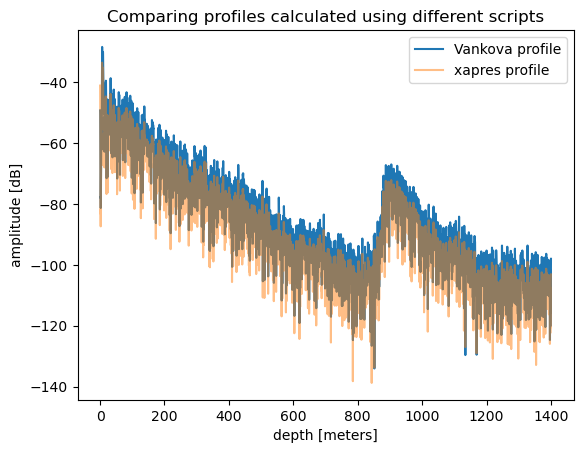

In [10]:
plt.plot(range_vankova,xa.dB(profile_vankova_1),label='Vankova profile')
xa.dB(ds_trimmed.profile_stacked.isel(time=0)).plot(alpha=0.5,label='xapres profile')
plt.legend()
plt.title('Comparing profiles calculated using different scripts')
plt.ylabel('amplitude [dB]')

Text(0, 0.5, 'amplitude [dB]')

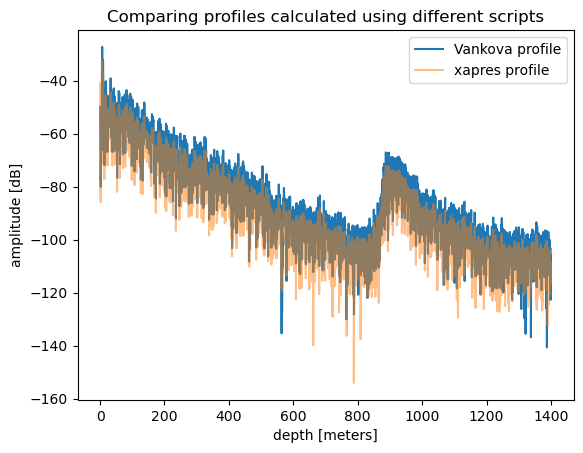

In [11]:
plt.plot(range_vankova,xa.dB(profile_vankova_2),label='Vankova profile')
xa.dB(ds_trimmed.profile_stacked.isel(time=94)).plot(alpha=0.5,label='xapres profile')
plt.legend()
plt.title('Comparing profiles calculated using different scripts')
plt.ylabel('amplitude [dB]')

It is a bit concerning that our determined stacked profiles do not align fully with those calculated using Irena's scripts. Though the general trends and peaks are reflected, there is an evident difference. One potential source of differences here is that the profile_stacked is calculated by averaging profiles, whereas Irena's code averages the chirps before generating the profiles. Let's try averaging the chirps and detemrining the profiles.

In [12]:
chirps = ds_trimmed.chirp.isel(time=0)
pad=2
F0=2e8
F1=4e8

StartFreq = 2e8
StopFreq = 4e8
B = StopFreq - StartFreq
CentreFreq = B/2
K = 2e8 
dt = 1/40000
c0 = 3e8 # speed of light in vaccuum
ER_ICE = 3.18
T0 = (F0-StartFreq)/K
T1 = (F1-StartFreq)/K

chirp = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
Nt = len(chirp)
Nt = math.floor(Nt/2) * 2
winchirp = np.multiply(chirp[0:Nt],np.blackman(Nt))
Nfft = math.floor(Nt*pad)

padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)-1] = winchirp[math.floor(Nt/2):-1]
padchirp[-math.floor(Nt/2):-1] = winchirp[0:math.floor(Nt/2)-1]

Profile = np.fft.fft(padchirp)/Nfft * math.sqrt(2*pad) 
bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
Range = np.asarray([i for i in range(Nfft)]) * bin2m       
Profile = Profile[0:math.floor(Nfft/2)-1]
Range = Range[0:math.floor(Nfft/2)-1]
m = np.asarray([i for i in range(len(Profile))])/pad
phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
Profile_ref = Profile * np.exp(phiref*(-1j))



Without Irena's modifications (aka just using our method but stacking the chirps first, there is a perfect overlap with our `profile_stacked` result which comes from taking the mean of all the profiles. Consequently it is not because of the order of calculations. 

Text(0, 0.5, 'amplitude [dB]')

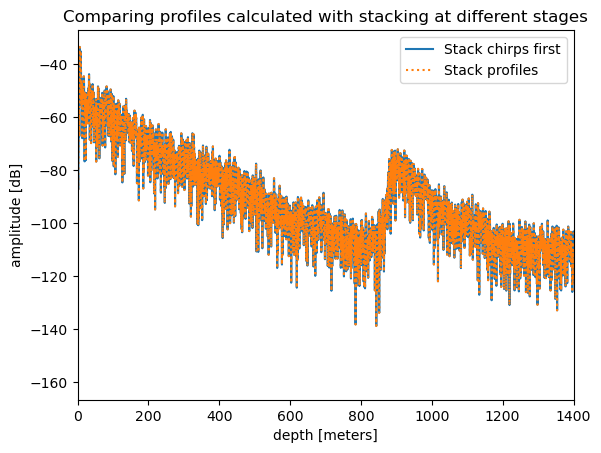

In [13]:
plt.plot(Range,xa.dB(Profile_ref),label='Stack chirps first')
plt.xlim([0,1400])
xa.dB(ds_trimmed.profile_stacked.isel(time=0)).plot(linestyle='dotted',label='Stack profiles')
plt.legend()
plt.title('Comparing profiles calculated with stacking at different stages')
plt.ylabel('amplitude [dB]')

Adding in Irena's modifications, at least all the ones I can identify

In [14]:
chirps = ds_trimmed.chirp.isel(time=0)
pad=2
F0=2e8
F1=4e8

StartFreq = 2e8
StopFreq = 4e8
B = StopFreq - StartFreq
CentreFreq = B/2
K = 2e8 
dt = 1/40000
c0 = 3e8 # speed of light in vaccuum
ER_ICE = 3.18
T0 = (F0-StartFreq)/K
T1 = (F1-StartFreq)/K

chirp = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
#chirp = chirp -np.mean(chirp) # added from Irena 
Nt = len(chirp)
Nt = math.floor(Nt/2) * 2
winchirp = np.multiply(chirp[0:Nt],np.blackman(Nt))
Nfft = math.floor(Nt*pad)

padchirp = np.zeros(Nfft)
padchirp[0:math.floor(Nt/2)-1] = winchirp[math.floor(Nt/2):-1]
padchirp[-math.floor(Nt/2):-1] = winchirp[0:math.floor(Nt/2)-1]
rms = np.sqrt(np.mean(np.blackman(Nt)**2)) # added from Irena 

Profile = np.fft.fft(padchirp)/(Nfft*rms) * math.sqrt(2*pad) 
bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
Range = np.asarray([i for i in range(Nfft)]) * bin2m       
Profile = Profile[0:math.floor(Nfft/2)-1]
Range = Range[0:math.floor(Nfft/2)-1]
m = np.asarray([i for i in range(len(Profile))])/pad
phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
Profile_ref = Profile * np.exp(phiref*(-1j))



This is a lot closer. We need to think about if these additional steps are necessary. It seems if we ignore the de-meaning, it's a bit more similar to Irena's output.

Text(0.5, 0, 'depth [m]')

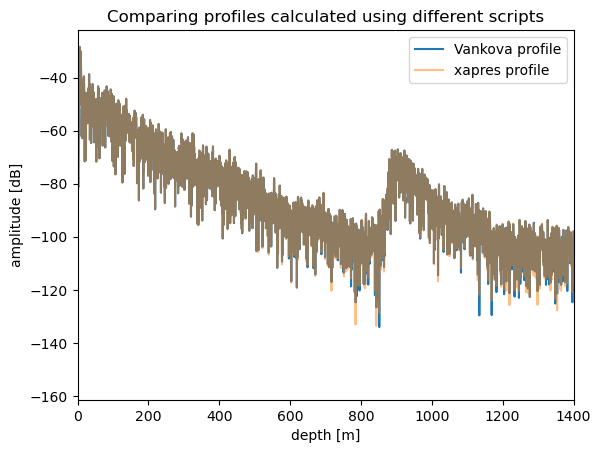

In [15]:
plt.plot(range_vankova,xa.dB(profile_vankova_1),label='Vankova profile')

plt.plot(Range,xa.dB(Profile_ref),alpha=0.5,label='xapres profile')
plt.xlim([0,1400])
plt.legend()
plt.title('Comparing profiles calculated using different scripts')
plt.ylabel('amplitude [dB]')
plt.xlabel('depth [m]')
#xa.dB(ds_trimmed.profile_stacked.isel(time=0)).plot(alpha=0.5)


Another possibility can be the chirp length - our resulting arrays are longer than Irena's by one. I need to think about how to investigate that still. In the meantime, let's move on to calculating the velocities, since as shown below, even without adjustment, our determined profiles align with Irena's

In [16]:
mat = scipy.io.loadmat('G1.mat')

In [17]:
profiles_ts_vankova = mat['site'][0][0][0]

In [18]:
time = ds_trimmed.time.values

Text(0.5, 1.0, 'A104 reflector amplitudes - Vankova')

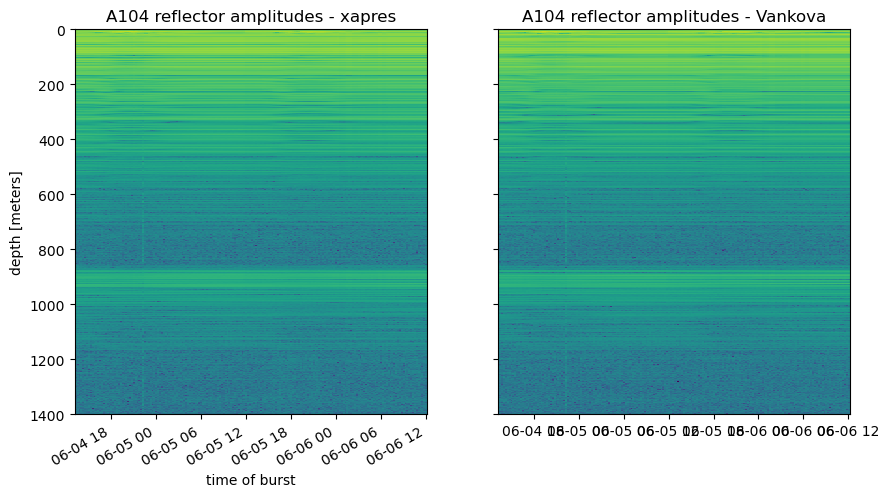

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize = (10,5))

xa.dB(ds_trimmed.profile_stacked).plot(ax=ax1,x='time',add_colorbar=False)
ax1.invert_yaxis()
ax1.set_title('A104 reflector amplitudes - xapres')
ax2.pcolormesh(time,range_vankova,np.transpose(xa.dB(profiles_ts_vankova)))
ax2.set_title('A104 reflector amplitudes - Vankova')


TODO: Compare with full vankova time series timestep by timestep. Qualitatively, looks very similar. Let's move on to range differences, to get velocities.

## Calculating Velocities
We start with our xapres-derived range differences

In [20]:
b1 = ds_trimmed.profile_stacked.isel(time=range(0,len(ds_trimmed.time)-1)).where(ds_trimmed.profile_range >= 10,drop=True)
b2 = ds_trimmed.profile_stacked.isel(time=range(1,len(ds_trimmed.time))).where(ds_trimmed.profile_range >= 10,drop=True)

This will give the range difference between each burst, without any phase wrapping. We use a correlation window and step of 19. We manually determined this such that the size of the resulting array matches with that of Irena's results

In [21]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     17:36:22 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [899. 902. 900. 901. 900. 900. 899. 900. 900. 900. 904. 896. 903. 904.
 900. 923. 869. 900. 909. 894. 898. 900. 900. 902. 898. 915. 903. 912.
 868. 900. 902. 898. 900. 901. 900. 901. 899. 931. 868. 900. 900. 901.
 900. 902. 900. 900. 900. 901. 900. 899. 900. 901. 900. 900. 900. 900.
 900. 900. 930. 870. 936. 878. 899. 897. 889. 901. 900. 899. 901. 900.
 900. 930. 869. 900. 900. 900. 930. 877. 923. 870. 907. 900. 904. 896.
 901. 899. 923. 877. 892. 908. 894. 900. 900. 900. 903. 897. 900. 900.
 900. 900. 912. 892. 897. 900. 900. 901. 899. 900. 900. 899. 900. 900.
 901. 899. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900. 900.
 900. 900. 900. 900. 900. 900. 900. 901. 905. 908. 918. 867. 900. 903.
 899. 900. 900. 899. 901. 902. 898. 905. 899. 903. 894. 899. 901. 899.
 900. 900. 900. 900. 900. 900. 900. 934. 866. 901. 899. 900. 900. 902.
 898. 900. 900. 900. 900. 900. 900. 900. 900. 900. 9

In [22]:
ds

<xarray.Dataset>
Dimensions:        (time: 187, profile_range: 347)
Coordinates:
  * time           (time) datetime64[ns] 2022-06-04T13:33:15 ... 2022-06-06T1...
  * profile_range  (profile_range) float64 11.99 15.98 ... 1.39e+03 1.394e+03
Data variables:
    time_diff      (time) float64 899.0 1.801e+03 ... 1.674e+05 1.683e+05
    range_diff     (time, profile_range) float64 -0.0003771 ... 0.02644
    err            (time, profile_range) float64 7.202e-05 3.798e-05 ... 0.01096

Text(0.5, 1.0, 'Range difference 15 minutes apart')

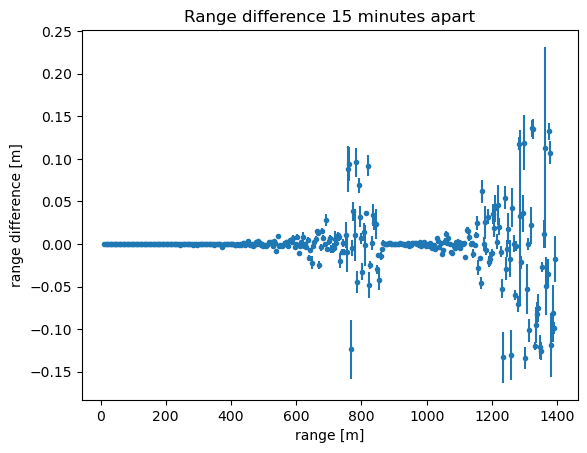

In [23]:
timestamp = ds.isel(time=0)
plt.errorbar(timestamp.profile_range,timestamp.range_diff,abs(timestamp.err),marker='.',linestyle='none')
plt.xlabel('range [m]')
plt.ylabel('range difference [m]')
plt.title('Range difference 15 minutes apart')

Let's compare this with Irena's results.

In [24]:
mat = scipy.io.loadmat('G1_ts_fine_TT.mat')

In [25]:
time_unwr = mat['ct'][0][0][0][0][0][0][0]
dh_unwr = mat['ct'][0][0][0][0][0][1]
dhrange_unwr = mat['ct'][0][0][0][0][0][2][0]


In [26]:
dh_xcor = mat['ct'][0][0][1][0][0][0]
ampcor = mat['ct'][0][0][1][0][0][1]
phasecor = mat['ct'][0][0][1][0][0][2]
dhrange_xcor = mat['ct'][0][0][1][0][0][3][0]
time_xcor = mat['ct'][0][0][1][0][0][4][0]

Text(0.5, 1.0, 'Range difference 15 minutes apart')

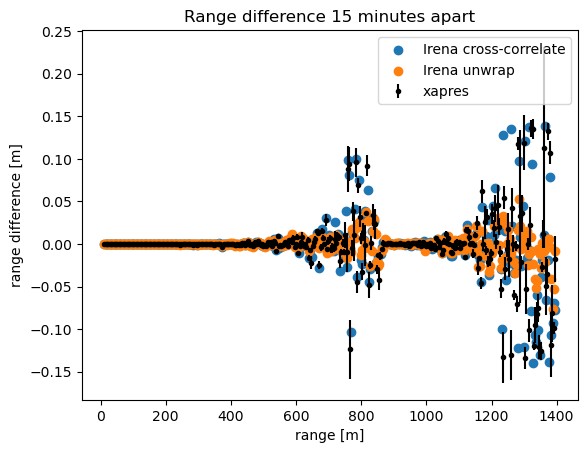

In [27]:
plt.scatter(dhrange_xcor,dh_xcor[1,:],label='Irena cross-correlate')
plt.scatter(dhrange_unwr,dh_unwr[1,:],label='Irena unwrap')

plt.errorbar(timestamp.profile_range,timestamp.range_diff,abs(timestamp.err),marker='.',linestyle='none',color='black',label = 'xapres')
plt.legend()
plt.xlabel('range [m]')
plt.ylabel('range difference [m]')
plt.title('Range difference 15 minutes apart')

Overall, given that our profiles look different, these calculated range differences are quite similar. The difference between our method (black) and the `xcor` method used by Irena (bue) is less than the difference between the two methods used by Irena. 

Text(0.5, 1.0, 'Xapres')

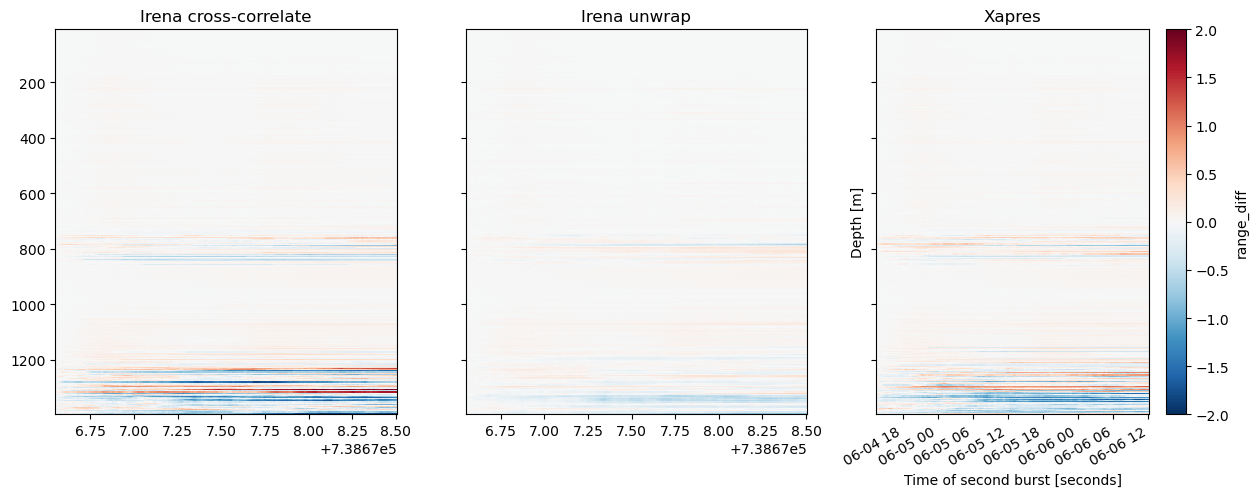

In [35]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize = (15,5))
ax1.pcolormesh(time_xcor,dhrange_xcor,np.transpose(dh_xcor),cmap='RdBu_r',vmin=-2,vmax=2)
ax1.set_title('Irena cross-correlate')
ax2.pcolormesh(time_unwr,dhrange_unwr,np.transpose(dh_unwr),cmap='RdBu_r',vmin=-2,vmax=2)
ax2.set_title('Irena unwrap')
ds.range_diff.cumsum(dim='time').plot(ax=ax3,x='time',cmap='RdBu_r',vmin=-2,vmax=2)
ax3.invert_yaxis()
ax3.set_title('Xapres')

## Block of test scripts here

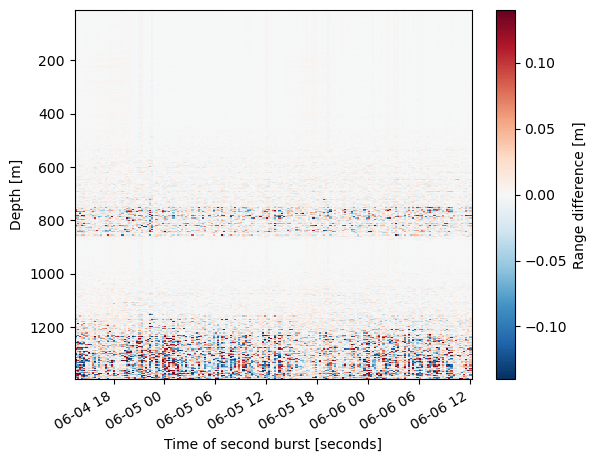

In [40]:
ds.range_diff.plot(x='time')
plt.gca().invert_yaxis()

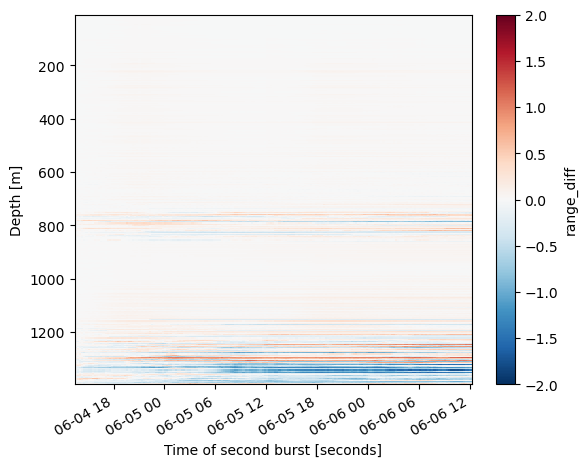

In [63]:
ds.range_diff.cumsum(dim='time').plot(x='time',cmap='RdBu_r',vmin=-2,vmax=2)
plt.gca().invert_yaxis()

Once again, the difference in our range difference calculation from Irena's is within the variation found in her two different methods.

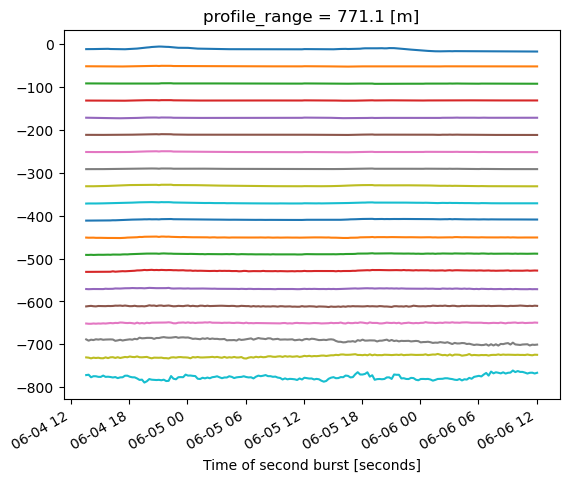

In [27]:
for i in np.arange(0,200,10):
    (100*ds.range_diff.cumsum(dim='time').isel(profile_range = i) - ds.range_diff.profile_range.isel(profile_range = i)).plot()


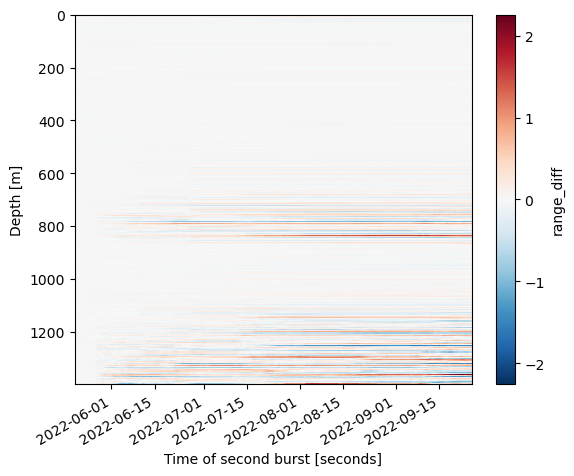

In [33]:
(ds.range_diff.cumsum(dim='time')).differentiate('profile_range').plot(x='time')
plt.gca().invert_yaxis()

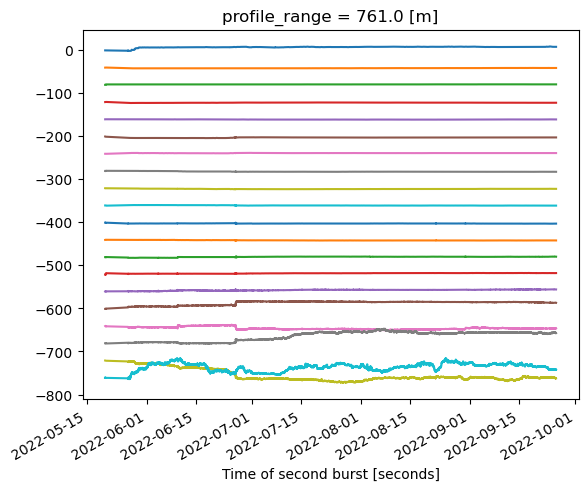

In [52]:
for i in np.arange(0,200,10):
    (100*ds.range_diff.cumsum(dim='time').differentiate('profile_range').isel(profile_range = i) - ds.range_diff.profile_range.isel(profile_range = i)).plot()


## Testing range diff across long time

In [7]:
ds_104

<xarray.Dataset>
Dimensions:          (attenuator_setting_pair: 2, time: 11741,
                      chirp_time: 40001, chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 00:00:00 ... 00:00:01
    filename         (time) <U83 dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 2022-05-19T23:19:34 ... 2022-09-25...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 dask.array<chunksize=(20, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    longitude        (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 dask.array<chunksize=(20, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>
    temperature_2    (time) float64 dask.array<chunksize=(20,), meta=np.ndarray>

In [29]:
ds_long = ds_104.profile_stacked.isel(attenuator_setting_pair = 0,time=range(100,len(ds_104.time.values))).where(ds_104.burst_number == 0).compute()


In [30]:
b1 = ds_long.isel(time=range(0,len(ds_long.time)-1)).where(ds_long.profile_range >= 10,drop=True)
b2 = ds_long.isel(time=range(1,len(ds_long.time))).where(ds_long.profile_range >= 10,drop=True)

In [31]:
ds, co, phi = xa.generate_range_diff(b1,b2,19,19,None,0,0.9)

INFO     18:47:26 	 ApRESDefs.py @function generate_range_diff line 594 - Time between bursts : [899. 900. 888. ... 903. 905. 897.]s


/home/jovyan/xapres_package/notebooks/test_notes/../../xapres_package/ApRESDefs.py:579: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


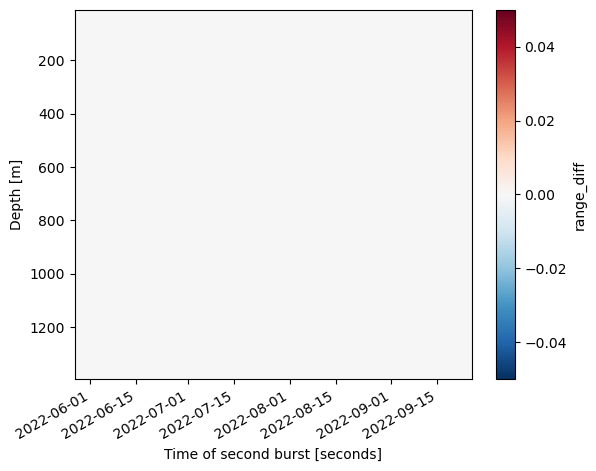

In [33]:
ds.range_diff.cumsum(dim='time').plot(x='time',cmap='RdBu_r')
plt.gca().invert_yaxis()

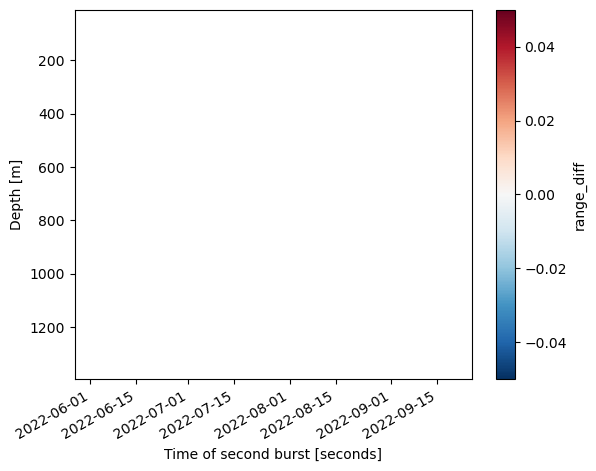

In [34]:
ds.range_diff.differentiate('profile_range').plot(x='time',cmap='RdBu_r')
plt.gca().invert_yaxis()

In [35]:
ds_long

<xarray.DataArray 'profile_stacked' (time: 11641, profile_range: 6658)>
array([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       ...,
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj]])
Coordinates:
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.4e+03 1.4e+03
  * time           (time) datetime64[ns] 2022-05-27T07:03:19 ... 2022-09-25T1...
    AFGain         int64 -4
    attenuator     float64 10.0
    burst_number   (time) int64 53 54 55 56 57 58 59 60 ... 6 7 8 9 10 11 12 13
    filename       (time) <U83 'ldeo-glaciology/GL_apres_2022/A104/CardA/DIR2...